In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import netCDF4
from erddapy import ERDDAP
import json

Configure the ERDDAP to search

In [2]:
ra = 'caricoos'

with open('utils/ra_erddaps.json') as f:
    urls = json.load(f)

server = urls[ra.lower()]

print(server)

e = ERDDAP(server=server, protocol="tabledap")

http://dm3.caricoos.org:8002/erddap


Pull in the processed inventory

In [3]:
#
# df_cruise = df[df['Station Description'] == 'Chesapeake Bay WQ Cruise Data ']
#
#df_aws = df[df['Station ID'] == 'Humboldt']
# #url = 'http://tds.glos.us/thredds/dodsC/buoy_agg_standard/OMOECC_E1/OMOECC_E1.ncml'
# #url = 'http://tds.glos.us/thredds/dodsC/buoy_agg_standard/45186/45186.ncml'
# #url = 'http://tds.glos.us/thredds/dodsC/buoy_agg_standard/bgsusd2/bgsusd2.ncml'
# url = 'http://oos.soest.hawaii.edu/thredds/dodsC/hioos/nss/ns12agg'
# print(url)
# ds = xr.open_dataset(url)
# #ds = netCDF4.Dataset(url,'r')
# title = ds.title
# start_time = np.datetime_as_string(ds.time.min().values, unit='D')
# end_time = np.datetime_as_string(ds.time.max().values, unit='D')
# print('Duration: %s - %s' % (np.datetime_as_string(ds.time.min().values, unit='D'),
#                              np.datetime_as_string(ds.time.max().values, unit='D'))
#       )

# Try glos web server
# url = 'https://glbuoys.glos.us/tools/export?ftype=csv&data_type=buoy&units=eng&locs=OMOECC_E1&params=Water_Temperature_at_Surface|dissolved_oxygen_saturation|water_conductivity|ysi_turbidity&tperiod=custom&date_start=2020-01-01&date_end=2020-12-31&avg_ivld=none'
# df = erddapy.ERDDAP.to_pandas(url)

## using ERDDAP to look for stations
# check out http://data.glos.us/erddap/tabledap/allDatasets.htmlTable?datasetID%2Ctitle%2CminTime%2CmaxTime&maxTime%3E=2020-01-01&maxTime%3C=2020-12-31&orderBy(%22maxTime%22)
# that lists out all the GLOS stations with the maximum time of observations within the year 2020 (on their ERDDAP).

df = pd.read_excel('2022/data/processed/%s.xlsx' % ra.upper(), dtype=str)
df

,RA,Station ID,WMO ID or NWS/CMAN ID,Station Long Name,Station Description,Latitude (dec deg),Longitude (dec deg),Platform Type,"Station Deployment (mm/yyyy, yyyy, < 5 yr, > 5 yr)","Currently Operational? (Y, N, O, U)",Platform Funder/Sponsor,"RA Funding Involvement (Yf, Yp, N)",Platform Operator/Owner,Operator Sector,Platform Maintainer,Data Manager,"Variable Names + water column depth of measurement in meters [CF_name (# m, # m) or CF_name (mult) or CF_name (# depths)].",Additional notes
0,CARICOOS,PR1,42085,Ponce Buoy,NaN,17.8687,-66.532,Moored buoy,06/2009 - present,Y,CARICOOS,Yf,Neil Pettigrew/CARICOOS,Academia,CARICOOS/University of Maine,"Department of Physical Oceanography, School of...","sea_water_speed (2.5 - 16) m, sea_water_to_dir...",NaN
1,CARICOOS,PR2,41053,San Juan Buoy,NaN,17.4743,-66.0994,Moored buoy,07/2010 - present,Y,CARICOOS,Yf,Neil Pettigrew/CARICOOS,Academia,CARICOOS/University of Maine,"Department of Physical Oceanography, School of...","sea_water_speed (2.5 - 29) m, sea_water_to_dir...",NaN
2,CARICOOS,PR3,41056,Vieques Buoy,NaN,18.2609,-65.464,Moored buoy,09/2013 - present,Y,CARICOOS,Yf,Neil Pettigrew/CARICOOS,Academia,CARICOOS/University of Maine,"Department of Physical Oceanography, School of...","sea_water_speed (2.5 - 28 m), sea_water_to_dir...",NaN
3,CARICOOS,VI1,41052,St. John Buoy,NaN,18.2491,-64.7637,Moored buoy,04/2011 - present,Y,CARICOOS,Yf,Neil Pettigrew/CARICOOS,Academia,CARICOOS/University of Maine,"Department of Physical Oceanography, School of...","sea_water_speed (2.5 - 40 m), sea_water_to_dir...",NaN
4,CARICOOS,VI2,41051,North of St. Thomas,NaN,18.4761,-65.1568,Moored buoy,08/2017-09/2017,O,CARICOOS,Yf,Neil Pettigrew/CARICOOS,Academia,CARICOOS/University of Maine,"Department of Physical Oceanography, School of...","sea_water_speed (2.5 - 22 m), sea_water_to_dir...",Damaged by Hurricane Irma. A new oceanographic...
5,CARICOOS,VIA,41051,North of St. Thomas,NaN,18.2574,-65.004,Moored buoy,03/2013-03/2015,N,CARICOOS,Yf,Neil Pettigrew/CARICOOS,Academia,University of Virgin Islands,"Department of Physical Oceanography, School of...","sea_water_speed (2.5 - 22 m), sea_water_to_dir...",Reployed in another location. Now is identifie...
6,CARICOOS,181p1,41115,Rincón Waverider Buoy,NaN,18.3764,-67.2799,Moored buoy,05/2011 - present,Y,CARICOOS/CDIP,N,"Coastal Data Information Program, SIO/UCSD/CAR...",Academia,CARICOOS,Coastal Data Information Program,"sea_surface_wave_significant_height, sea_surfa...",NaN
7,CARICOOS,249p1,41121,Arecibo Waverider Buoy,NaN,18.4909,-66.7005,Moored buoy,05/2021 - present,Y,CARICOOS/CDIP/NREL,Yf,"Coastal Data Information Program, SIO/UCSD/CAR...",Government-Federal/Academia,CARICOOS,Coastal Data Information Program,"sea_surface_wave_significant_height, sea_surfa...",NaN
8,CARICOOS,MAPCO2,NCEI Accession 0117354,La Parguera MapCO2 buoy,NCEI Accession 0117354,17.953666666666667,-66.0512,Moored buoy,2009 - present,Y,PMEL/CARICOOS,Yp,PMEL,Academia,CARICOOS,PMEL/CARICOOS,"SST, SSS, Atm. press, xCO2 water, xCO2 air, fC...",NaN
9,CARICOOS,PUNTAS,PTRP4,"Rincón, PR",NaN,18.3667,-67.2514,Fixed,11/2012 - present,O,CARICOOS,Yf,CARICOOS,Academia/Non-Profit,CARICOOS,NDBC / CARICOOS,"wind_speed (15 m), wind_speed_of_gust (15 m), ...",Issues with the data logger. CARICOOS will rep...


Search the ERDDAP server for a single station of interest - more of a test

In [4]:
# df['Station ID'].loc[df['Station ID'].isna()] = df.loc[df['Station ID'].isna(),'Dataset ID']

# df['Station ID']

In [5]:
# df_wf = df[df['Station ID'] == 'Jug_Bay']

# # for SCCOOS need to search for 'Station Long Name' as 'Station ID' is NA for most entries
# search_for = df_wf['Station ID'].to_string()

# search_url = e.get_search_url(search_for=search_for, response="csv")

# try:
#     resp = pd.read_csv(search_url)
#     print(resp['Station ID'])
# except:
#     pass

Rip through all the datasets in the inventory and see if they exist on the RA erddap. Process checks the following order:

1. `Station ID`, then 
2. `Station Long Name`, then
3. `WMO ID or NWS/CMAN ID`

We first check if the value is `nan`. If so, we punt as that will return all datasets from the ERDDAP service.

In [24]:
not_found = []
found = dict()

exclude = ' -gliders'

search_order = ['Station ID', 'Station Long Name', 'WMO ID or NWS/CMAN ID']

for search1 in df[search_order[0]].astype(str):
    
    if search1 == "nan":
        print("punting with %s = nan\n" % search_order[0])
        not_found.append(search1)
        continue
    
    try:
        print('searching \"%s\" = \"%s\"' % (search_order[0], search1))
        search_url = e.get_search_url(search_for=search1+exclude, response="csv")
        resp = pd.read_csv(search_url)
        
        print("Found \"%s\": %s" % (search1,resp['Dataset ID'].values.tolist()))
        
        found[search1] = {'Dataset ID': resp['Dataset ID'].values.tolist()}
        
    except:
        
        print('no dataset matching \"%s\"' % search1)
        search2 = df.loc[df[search_order[0]] == search1, search_order[1]].values.tolist()[0]
        
        if search2 == "nan":
                print("punting with %s = nan\n" % search_order[1])
                not_found.append(search1)
                continue
                
        try:
            
            print('searching \"%s\" = \"%s\"' % (search_order[1], search2))
            search_url = e.get_search_url(search_for=search2+exclude, response="csv")
            resp = pd.read_csv(search_url)
            print("Found \"%s\": %s" % (search2,resp['Dataset ID'].values.tolist()))
            
            found[search1] = {'Dataset ID': resp['Dataset ID'].values.tolist()}
            
        except:

            search3 = str(df.loc[df[search_order[0]] == search1, search_order[2]].values.tolist()[0])
            
            if search3 == "nan":
                print("punting with \"%s\" = nan\n" % search_order[2])
                not_found.append(search1)
                continue
            
            try:
                print('searching \"%s\" = \"%s\"' % (search_order[2], search3))
                search_url = e.get_search_url(search_for=search3+exclude, response="csv")
                resp = pd.read_csv(search_url)
                print("Found \"%s\": %s" % (search3,resp['Dataset ID'].values.tolist()))
                
                found[search1] = {'Dataset ID': resp['Dataset ID'].values.tolist()}
                
            except:
                print("Couldn't find:", [search1, search2, search3])
                not_found.append(search1)
        
    print("\n")

searching "Station ID" = "PR1"
Found "PR1": ['PR1_doppler_5e96_75ee_2a90', 'PR1_sbe_f2d2_f08a_3de6', 'PR1_triaxys_ad35_042f_ee54', 'PR1_met_02ff_fa06_8f89']


searching "Station ID" = "PR2"
Found "PR2": ['PR2_doppler_34d7_c61a_a162', 'PR2_sbe_4bd8_cdd4_f3a1', 'PR2_triaxys_8b12_c1a2_3611', 'buoy_erddap_12bc_0293_5a40']


searching "Station ID" = "PR3"
Found "PR3": ['PR3_doppler_b3ca_6da8_3d0e', 'PR3_sbe_dea3_226c_8bd7', 'PR3_met_cef1_bff2_f25b', 'PR3_waves_3d94_aeda_8139']


searching "Station ID" = "VI1"
Found "VI1": ['VI1_doppler_200f_7ac1_2075', 'VI1_sbe_f867_8696_97f1', 'VI1_triaxys_ee48_77fd_a313', 'VI1_met_60d8_4131_a3f0']


searching "Station ID" = "VI2"
Found "VI2": ['VI2_doppler_36f0_5d1f_762a', 'VI2_waves_1f59_412f_3b40', 'VI2_met_599b_402a_1961', 'VI2_wqm_1e83_3b14_057e']


searching "Station ID" = "VIA"
Found "VIA": ['VIA_doppler_7454_e002_60ee', 'VIA_wqm_5e00_012a_371c', 'VIA_waves_3dae_8bcb_1992', 'VIA_met_596a_fd3e_713e']


searching "Station ID" = "181p1"
Found "181p1": 

Print the stations that we couldn't find.

In [25]:
len(not_found)

3

In [26]:
len(found)

27

Show me the record that has NaN for the first search element.

In [28]:
df.loc[df[search_order[0]].isna()]

,RA,Station ID,WMO ID or NWS/CMAN ID,Station Long Name,Station Description,Latitude,Longitude,Platform Type,Station Deployment,"Currently Operational? (Y, N, O, U)",Platform Funder/Sponsor,"RA Funding Involvement (Yf, Yp, N)",Platform Operator/Owner,Operator Sector,Platform Maintainer,Data Manager,Variable Names,Additional notes,erddap_avail,geometry
30,CARICOOS,NaN,NaN,"Mountain Top, USVI",NaN,18.36,-64.95,Fixed,2019-present,N,Weatherflow /CARICOOS/OCOVI,Yf,CARICOOS,Industry,CARICOOS,Weatherflow /CARICOOS/OCOVI,"wind_speed (10 m), wind_speed_of_gust (10 m), ...",This station replace Crown Mountain Station ho...,True,POINT (-64.95000 18.36000)


Now show me the stations, with identifiers, that we couldn't find.

In [31]:
df[df[search_order[0]].isin(not_found)]

,RA,Station ID,WMO ID or NWS/CMAN ID,Station Long Name,Station Description,Latitude,Longitude,Platform Type,Station Deployment,"Currently Operational? (Y, N, O, U)",Platform Funder/Sponsor,"RA Funding Involvement (Yf, Yp, N)",Platform Operator/Owner,Operator Sector,Platform Maintainer,Data Manager,Variable Names,Additional notes,erddap_avail,geometry
7,CARICOOS,249p1,41121,Arecibo Waverider Buoy,NaN,18.4909,-66.7005,Moored buoy,05/2021 - present,Y,CARICOOS/CDIP/NREL,Yf,"Coastal Data Information Program, SIO/UCSD/CAR...",Government-Federal/Academia,CARICOOS,Coastal Data Information Program,"sea_surface_wave_significant_height, sea_surfa...",NaN,False,POINT (-66.70050 18.49090)
8,CARICOOS,MAPCO2,NCEI Accession 0117354,La Parguera MapCO2 buoy,NCEI Accession 0117354,17.953666666666667,-66.0512,Moored buoy,2009 - present,Y,PMEL/CARICOOS,Yp,PMEL,Academia,CARICOOS,PMEL/CARICOOS,"SST, SSS, Atm. press, xCO2 water, xCO2 air, fC...",NaN,False,POINT (-66.05120 17.95367)


Print out all the dataset IDs for the datasets that matched our criteria.

In [34]:
found

{'PR1': {'Dataset ID': ['PR1_doppler_5e96_75ee_2a90',
   'PR1_sbe_f2d2_f08a_3de6',
   'PR1_triaxys_ad35_042f_ee54',
   'PR1_met_02ff_fa06_8f89']},
 'PR2': {'Dataset ID': ['PR2_doppler_34d7_c61a_a162',
   'PR2_sbe_4bd8_cdd4_f3a1',
   'PR2_triaxys_8b12_c1a2_3611',
   'buoy_erddap_12bc_0293_5a40']},
 'PR3': {'Dataset ID': ['PR3_doppler_b3ca_6da8_3d0e',
   'PR3_sbe_dea3_226c_8bd7',
   'PR3_met_cef1_bff2_f25b',
   'PR3_waves_3d94_aeda_8139']},
 'VI1': {'Dataset ID': ['VI1_doppler_200f_7ac1_2075',
   'VI1_sbe_f867_8696_97f1',
   'VI1_triaxys_ee48_77fd_a313',
   'VI1_met_60d8_4131_a3f0']},
 'VI2': {'Dataset ID': ['VI2_doppler_36f0_5d1f_762a',
   'VI2_waves_1f59_412f_3b40',
   'VI2_met_599b_402a_1961',
   'VI2_wqm_1e83_3b14_057e']},
 'VIA': {'Dataset ID': ['VIA_doppler_7454_e002_60ee',
   'VIA_wqm_5e00_012a_371c',
   'VIA_waves_3dae_8bcb_1992',
   'VIA_met_596a_fd3e_713e']},
 '181p1': {'Dataset ID': ['caricoosWaveRinconSst', 'caricoosWaveRinconWave']},
 'PUNTAS': {'Dataset ID': ['ptrp4_c6ab_61

Check if each found dataset has coverage for specified CY

In [35]:
valid_datasets = []

cy = '2022'

for key in found:
    
    dataset_id = found[key]['Dataset ID']
    
    if len(dataset_id)>1:
        
        for dataset in dataset_id:
            
            e.dataset_id = dataset
    
            e.constraints = {
                 "time>=": "{}-01-01".format(cy)
            }
        
            e.variables = ['time']
    
            try:
                df_data = e.to_pandas(parse_dates=True)
                valid_datasets.extend([key])
                
            except:
                pass

                #print("No data for 2021 for %s: dataset ID %s" % (key,e.dataset_id))

    else:
        
        e.dataset_id = dataset_id[0]
    
        e.constraints = {
                         "time>=": "{}-01-01".format(cy)
                        }
        
        e.variables = ['time']
        
        try:
            
            df_data = e.to_pandas(parse_dates=True)

            valid_datasets.extend([key])

        except:
            pass

            #print("No data for 2021 for %s: dataset ID %s" % (key,e.dataset_id))

            
#for valid in sorted(set(valid_datasets)):
    
#     # drop qc vars
#     cols = [c for c in df_data.columns if 'qc' not in c]
#     cols = [c for c in cols if 'QARTOD' not in c]

#     df_data = df_data[cols]

#     # set index for plotting
#     df_data = df_data.set_index(df_data['time (UTC)'])

#     # plot
#     #df_data.plot(subplots=True, title=e.dataset_id,figsize=(20,20))

#     start_time = df_data['time (UTC)'].min()
#     end_time = df_data['time (UTC)'].max()

#     print('Dataset %s' % e.dataset_id)
#     print('Duration: %s - %s' % (start_time, end_time))

no_cov_datasets = found.keys() - sorted(set(valid_datasets))

print('Datasets without coverage for {}:\n{}'.format(cy,no_cov_datasets))

Datasets without coverage for 2022:
{'XWGO', 'XAMA', 'VIA', 'VI2', 'XSAV'}


Show me the inventory metadata about the invalid stations:

In [37]:
bad_stations = df.loc[(df[search_order[0]].isin(no_cov_datasets)) | df[search_order[0]].isin(not_found)]

df['erddap_not_avail'] = df[search_order[0]].isin(bad_stations[search_order[0]])

df.loc[df['erddap_not_avail']]

,RA,Station ID,WMO ID or NWS/CMAN ID,Station Long Name,Station Description,Latitude,Longitude,Platform Type,Station Deployment,"Currently Operational? (Y, N, O, U)",...,"RA Funding Involvement (Yf, Yp, N)",Platform Operator/Owner,Operator Sector,Platform Maintainer,Data Manager,Variable Names,Additional notes,erddap_avail,geometry,erddap_not_avail
4,CARICOOS,VI2,41051,North of St. Thomas,NaN,18.4761,-65.1568,Moored buoy,08/2017-09/2017,O,...,Yf,Neil Pettigrew/CARICOOS,Academia,CARICOOS/University of Maine,"Department of Physical Oceanography, School of...","sea_water_speed (2.5 - 22 m), sea_water_to_dir...",Damaged by Hurricane Irma. A new oceanographic...,False,POINT (-65.15680 18.47610),True
5,CARICOOS,VIA,41051,North of St. Thomas,NaN,18.2574,-65.004,Moored buoy,03/2013-03/2015,N,...,Yf,Neil Pettigrew/CARICOOS,Academia,University of Virgin Islands,"Department of Physical Oceanography, School of...","sea_water_speed (2.5 - 22 m), sea_water_to_dir...",Reployed in another location. Now is identifie...,False,POINT (-65.00400 18.25740),True
7,CARICOOS,249p1,41121,Arecibo Waverider Buoy,NaN,18.4909,-66.7005,Moored buoy,05/2021 - present,Y,...,Yf,"Coastal Data Information Program, SIO/UCSD/CAR...",Government-Federal/Academia,CARICOOS,Coastal Data Information Program,"sea_surface_wave_significant_height, sea_surfa...",NaN,False,POINT (-66.70050 18.49090),True
8,CARICOOS,MAPCO2,NCEI Accession 0117354,La Parguera MapCO2 buoy,NCEI Accession 0117354,17.953666666666667,-66.0512,Moored buoy,2009 - present,Y,...,Yp,PMEL,Academia,CARICOOS,PMEL/CARICOOS,"SST, SSS, Atm. press, xCO2 water, xCO2 air, fC...",NaN,False,POINT (-66.05120 17.95367),True
16,CARICOOS,XAMA,TIMA,"Charlotte Amalie Harbor, USVI",NaN,18.3303,-64.9264,Fixed,2009 - 2015,N,...,N,CARICOOS,Industry,CARICOOS,Weatherflow /CARICOOS,"wind_speed (10 m), wind_speed_of_gust (10 m), ...",NaN,False,POINT (-64.92640 18.33030),True
27,CARICOOS,XSAV,TIAC,"Savanah Island, USVI",NaN,18.33737,-65.083,Fixed,2009 - 2017,N,...,N,CARICOOS,Industry,CARICOOS,Weatherflow /CARICOOS,"wind_speed (10 m), wind_speed_of_gust (10 m), ...",Decomissioned by Weatherflow because it got da...,False,POINT (-65.08300 18.33737),True
28,CARICOOS,XWGO,TIGO,"Crown Mountain, USVI",NaN,18.35537,-64.96693,Fixed,2009 - 2017,N,...,Yf,CARICOOS,Industry,CARICOOS,Weatherflow /CARICOOS,"wind_speed (10 m), wind_speed_of_gust (10 m), ...",Damaged by Hurricane Maria. A new station will...,False,POINT (-64.96693 18.35537),True


Invert the `erddap_not_avail` column and drop it.

In [38]:
df['erddap_avail'] = ~df['erddap_not_avail']

df.drop(columns='erddap_not_avail', inplace=True)

df

,RA,Station ID,WMO ID or NWS/CMAN ID,Station Long Name,Station Description,Latitude,Longitude,Platform Type,Station Deployment,"Currently Operational? (Y, N, O, U)",Platform Funder/Sponsor,"RA Funding Involvement (Yf, Yp, N)",Platform Operator/Owner,Operator Sector,Platform Maintainer,Data Manager,Variable Names,Additional notes,erddap_avail,geometry
0,CARICOOS,PR1,42085,Ponce Buoy,NaN,17.8687,-66.532,Moored buoy,06/2009 - present,Y,CARICOOS,Yf,Neil Pettigrew/CARICOOS,Academia,CARICOOS/University of Maine,"Department of Physical Oceanography, School of...","sea_water_speed (2.5 - 16) m, sea_water_to_dir...",NaN,True,POINT (-66.53200 17.86870)
1,CARICOOS,PR2,41053,San Juan Buoy,NaN,17.4743,-66.0994,Moored buoy,07/2010 - present,Y,CARICOOS,Yf,Neil Pettigrew/CARICOOS,Academia,CARICOOS/University of Maine,"Department of Physical Oceanography, School of...","sea_water_speed (2.5 - 29) m, sea_water_to_dir...",NaN,True,POINT (-66.09940 17.47430)
2,CARICOOS,PR3,41056,Vieques Buoy,NaN,18.2609,-65.464,Moored buoy,09/2013 - present,Y,CARICOOS,Yf,Neil Pettigrew/CARICOOS,Academia,CARICOOS/University of Maine,"Department of Physical Oceanography, School of...","sea_water_speed (2.5 - 28 m), sea_water_to_dir...",NaN,True,POINT (-65.46400 18.26090)
3,CARICOOS,VI1,41052,St. John Buoy,NaN,18.2491,-64.7637,Moored buoy,04/2011 - present,Y,CARICOOS,Yf,Neil Pettigrew/CARICOOS,Academia,CARICOOS/University of Maine,"Department of Physical Oceanography, School of...","sea_water_speed (2.5 - 40 m), sea_water_to_dir...",NaN,True,POINT (-64.76370 18.24910)
4,CARICOOS,VI2,41051,North of St. Thomas,NaN,18.4761,-65.1568,Moored buoy,08/2017-09/2017,O,CARICOOS,Yf,Neil Pettigrew/CARICOOS,Academia,CARICOOS/University of Maine,"Department of Physical Oceanography, School of...","sea_water_speed (2.5 - 22 m), sea_water_to_dir...",Damaged by Hurricane Irma. A new oceanographic...,False,POINT (-65.15680 18.47610)
5,CARICOOS,VIA,41051,North of St. Thomas,NaN,18.2574,-65.004,Moored buoy,03/2013-03/2015,N,CARICOOS,Yf,Neil Pettigrew/CARICOOS,Academia,University of Virgin Islands,"Department of Physical Oceanography, School of...","sea_water_speed (2.5 - 22 m), sea_water_to_dir...",Reployed in another location. Now is identifie...,False,POINT (-65.00400 18.25740)
6,CARICOOS,181p1,41115,Rincón Waverider Buoy,NaN,18.3764,-67.2799,Moored buoy,05/2011 - present,Y,CARICOOS/CDIP,N,"Coastal Data Information Program, SIO/UCSD/CAR...",Academia,CARICOOS,Coastal Data Information Program,"sea_surface_wave_significant_height, sea_surfa...",NaN,True,POINT (-67.27990 18.37640)
7,CARICOOS,249p1,41121,Arecibo Waverider Buoy,NaN,18.4909,-66.7005,Moored buoy,05/2021 - present,Y,CARICOOS/CDIP/NREL,Yf,"Coastal Data Information Program, SIO/UCSD/CAR...",Government-Federal/Academia,CARICOOS,Coastal Data Information Program,"sea_surface_wave_significant_height, sea_surfa...",NaN,False,POINT (-66.70050 18.49090)
8,CARICOOS,MAPCO2,NCEI Accession 0117354,La Parguera MapCO2 buoy,NCEI Accession 0117354,17.953666666666667,-66.0512,Moored buoy,2009 - present,Y,PMEL/CARICOOS,Yp,PMEL,Academia,CARICOOS,PMEL/CARICOOS,"SST, SSS, Atm. press, xCO2 water, xCO2 air, fC...",NaN,False,POINT (-66.05120 17.95367)
9,CARICOOS,PUNTAS,PTRP4,"Rincón, PR",NaN,18.3667,-67.2514,Fixed,11/2012 - present,O,CARICOOS,Yf,CARICOOS,Academia/Non-Profit,CARICOOS,NDBC / CARICOOS,"wind_speed (15 m), wind_speed_of_gust (15 m), ...",Issues with the data logger. CARICOOS will rep...,True,POINT (-67.25140 18.36670)


Make a plot of all points and color based on ERDDAP available or not.

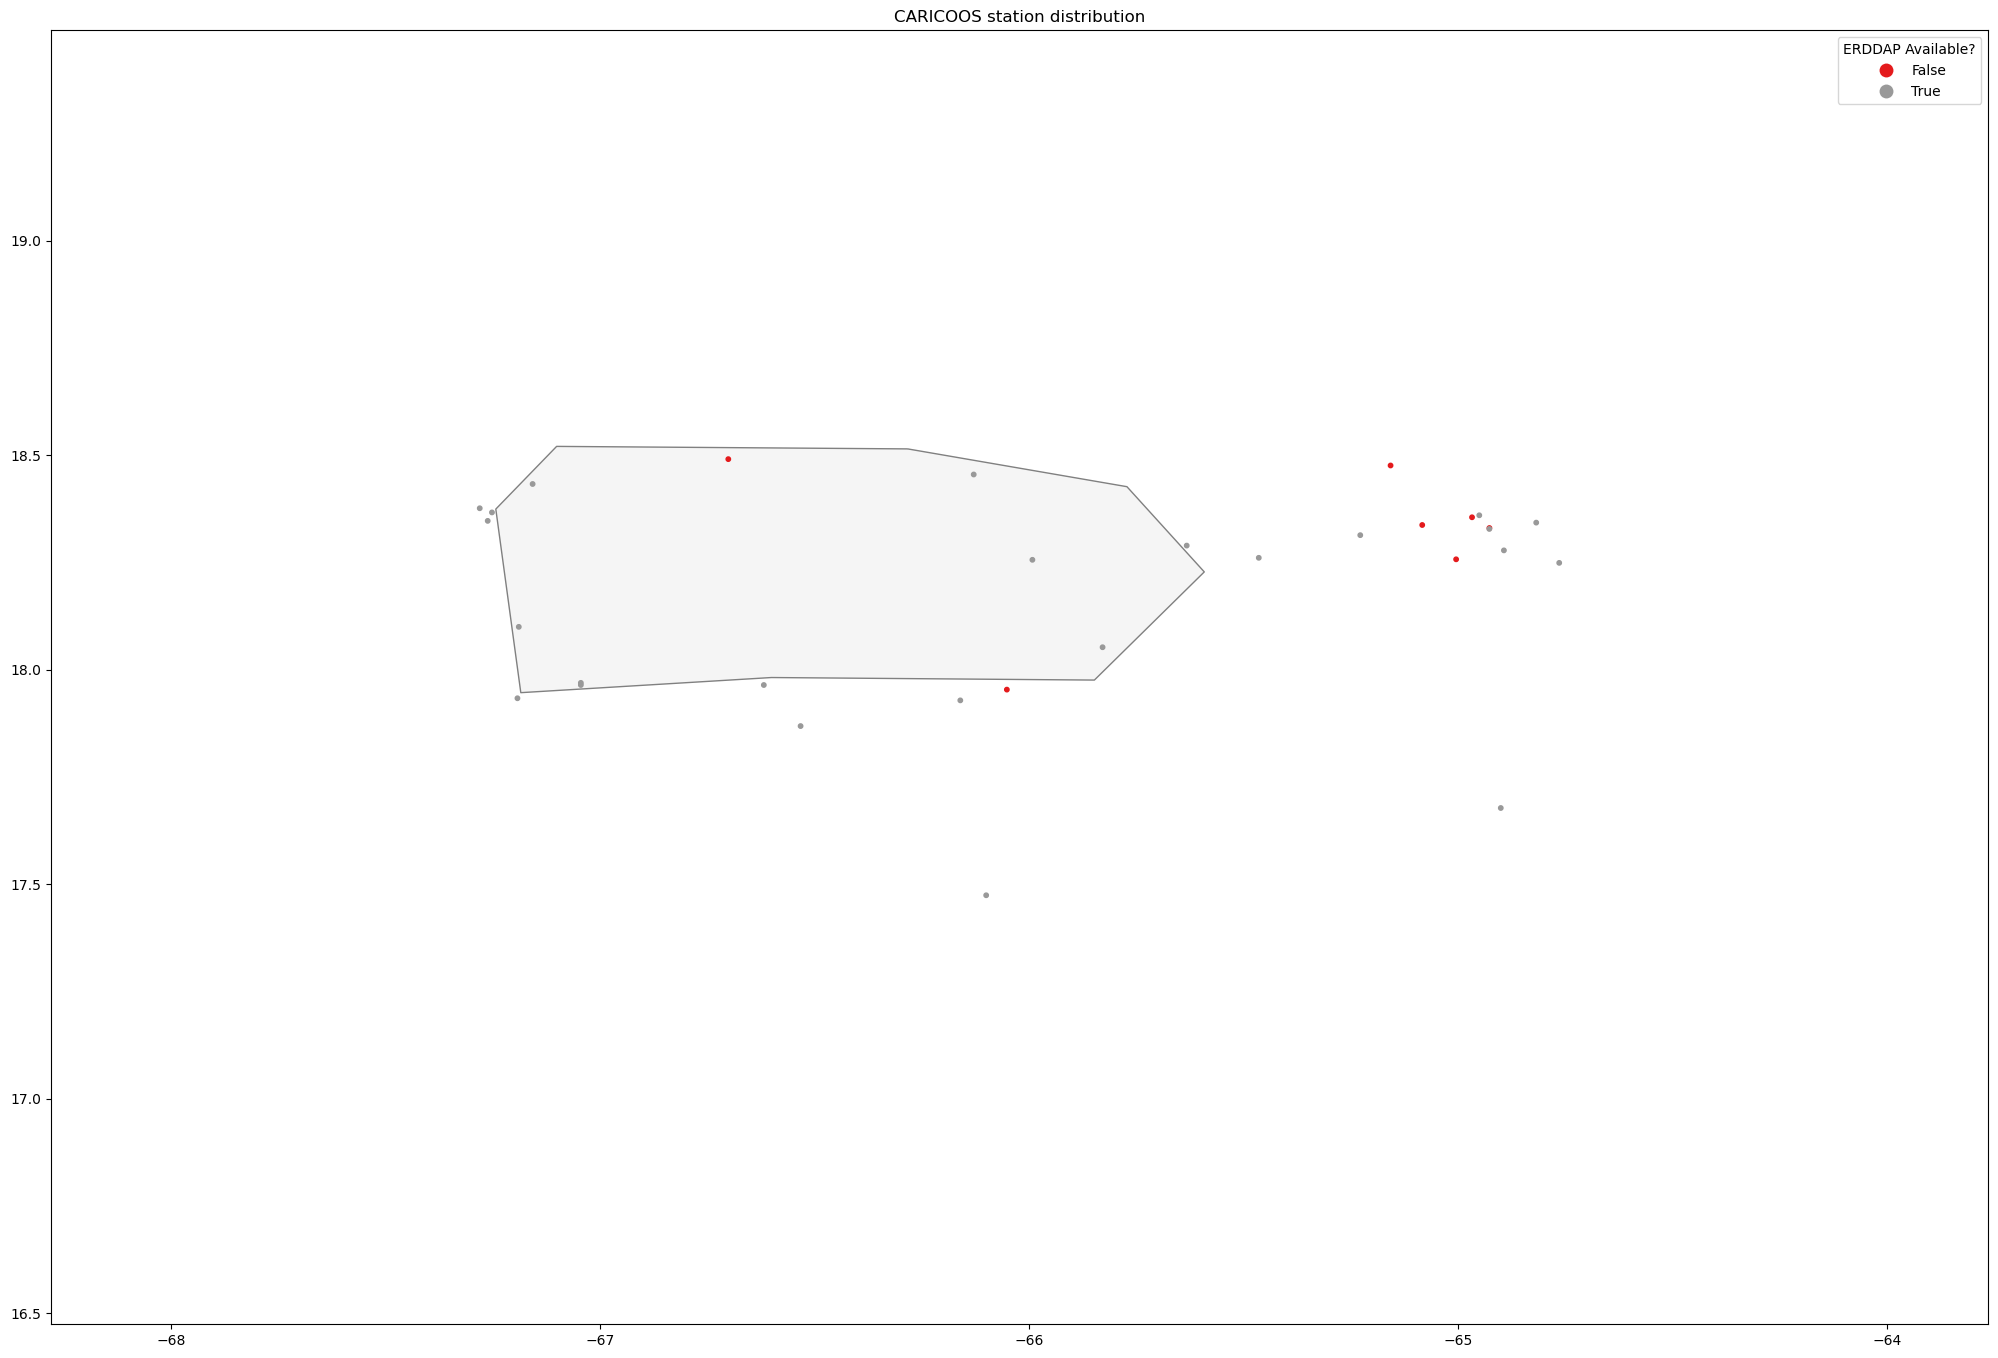

In [39]:
import geopandas
import matplotlib.pyplot as plt

#df = df.loc[df['']]

df.rename(columns=
{'Variable Names + water column depth of measurement in meters [CF_name (# m, # m) or CF_name (mult) or CF_name (# depths)].':
     'Variable Names',
 'Station Deployment (mm/yyyy, yyyy, < 5 yr, > 5 yr)': 'Station Deployment',
 'Longitude (dec deg)': 'Longitude',
 'Latitude (dec deg)': 'Latitude'},
              inplace=True)

df['Station Deployment'] = \
    df['Station Deployment'].astype(str)


gdf = geopandas.GeoDataFrame(
    df, geometry=geopandas.points_from_xy(df['Longitude'], df['Latitude']))

world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

ax = world.plot(
    color='whitesmoke', 
    edgecolor='grey', 
    figsize=(25,20),
    )

gdf.plot( ax=ax,
         column='erddap_avail', 
         categorical=True, 
         cmap = 'Set1',
         markersize=10, 
         legend=True,
         legend_kwds={'title': "ERDDAP Available?"},
         k=2,
        )



minx, miny, maxx, maxy = gdf.total_bounds
ax.set_xlim(minx-1, maxx+1)
ax.set_ylim(miny-1, maxy+1)

plt.title('{} station distribution'.format(ra))

plt.show()

Make an interactive map.

When you click on a point the return is the information from the inventory.

In [40]:
gdf_final = gdf.set_crs(epsg=4326)

gdf_final.drop(columns='Variable Names').explore('erddap_avail',cmap = 'Set1')


## Show me some bad coordinates

_if there are any_

In [41]:
gdf_final.loc[gdf_final['geometry'].is_empty == True]

,RA,Station ID,WMO ID or NWS/CMAN ID,Station Long Name,Station Description,Latitude,Longitude,Platform Type,Station Deployment,"Currently Operational? (Y, N, O, U)",Platform Funder/Sponsor,"RA Funding Involvement (Yf, Yp, N)",Platform Operator/Owner,Operator Sector,Platform Maintainer,Data Manager,Variable Names,Additional notes,erddap_avail,geometry


In [19]:
# import urllib.request
# for url in gdf_final.loc[gdf_final['erddap_not_avail'],'Station Description'].str.replace('url: ',''):
#     print(url)
#     try:
#         urllib.request.urlopen(url).getcode()
#     except:
#         print("URL broken: %s" % url)
#         print(gdf_final.loc[gdf_final['Station Description'].str.contains(url,regex=False),'Station ID'])

# Show me the stations where ERDDAP doesn't exist or provide a valid response.

Reasons:
* Station not found on RA erddap
* dataset found but no data for this CY.

In [42]:
gdf_final.loc[~gdf_final['erddap_avail']]

,RA,Station ID,WMO ID or NWS/CMAN ID,Station Long Name,Station Description,Latitude,Longitude,Platform Type,Station Deployment,"Currently Operational? (Y, N, O, U)",Platform Funder/Sponsor,"RA Funding Involvement (Yf, Yp, N)",Platform Operator/Owner,Operator Sector,Platform Maintainer,Data Manager,Variable Names,Additional notes,erddap_avail,geometry
4,CARICOOS,VI2,41051,North of St. Thomas,NaN,18.4761,-65.1568,Moored buoy,08/2017-09/2017,O,CARICOOS,Yf,Neil Pettigrew/CARICOOS,Academia,CARICOOS/University of Maine,"Department of Physical Oceanography, School of...","sea_water_speed (2.5 - 22 m), sea_water_to_dir...",Damaged by Hurricane Irma. A new oceanographic...,False,POINT (-65.15680 18.47610)
5,CARICOOS,VIA,41051,North of St. Thomas,NaN,18.2574,-65.004,Moored buoy,03/2013-03/2015,N,CARICOOS,Yf,Neil Pettigrew/CARICOOS,Academia,University of Virgin Islands,"Department of Physical Oceanography, School of...","sea_water_speed (2.5 - 22 m), sea_water_to_dir...",Reployed in another location. Now is identifie...,False,POINT (-65.00400 18.25740)
7,CARICOOS,249p1,41121,Arecibo Waverider Buoy,NaN,18.4909,-66.7005,Moored buoy,05/2021 - present,Y,CARICOOS/CDIP/NREL,Yf,"Coastal Data Information Program, SIO/UCSD/CAR...",Government-Federal/Academia,CARICOOS,Coastal Data Information Program,"sea_surface_wave_significant_height, sea_surfa...",NaN,False,POINT (-66.70050 18.49090)
8,CARICOOS,MAPCO2,NCEI Accession 0117354,La Parguera MapCO2 buoy,NCEI Accession 0117354,17.953666666666667,-66.0512,Moored buoy,2009 - present,Y,PMEL/CARICOOS,Yp,PMEL,Academia,CARICOOS,PMEL/CARICOOS,"SST, SSS, Atm. press, xCO2 water, xCO2 air, fC...",NaN,False,POINT (-66.05120 17.95367)
16,CARICOOS,XAMA,TIMA,"Charlotte Amalie Harbor, USVI",NaN,18.3303,-64.9264,Fixed,2009 - 2015,N,Weatherflow /CARICOOS,N,CARICOOS,Industry,CARICOOS,Weatherflow /CARICOOS,"wind_speed (10 m), wind_speed_of_gust (10 m), ...",NaN,False,POINT (-64.92640 18.33030)
27,CARICOOS,XSAV,TIAC,"Savanah Island, USVI",NaN,18.33737,-65.083,Fixed,2009 - 2017,N,Weatherflow /CARICOOS,N,CARICOOS,Industry,CARICOOS,Weatherflow /CARICOOS,"wind_speed (10 m), wind_speed_of_gust (10 m), ...",Decomissioned by Weatherflow because it got da...,False,POINT (-65.08300 18.33737)
28,CARICOOS,XWGO,TIGO,"Crown Mountain, USVI",NaN,18.35537,-64.96693,Fixed,2009 - 2017,N,Weatherflow /CARICOOS,Yf,CARICOOS,Industry,CARICOOS,Weatherflow /CARICOOS,"wind_speed (10 m), wind_speed_of_gust (10 m), ...",Damaged by Hurricane Maria. A new station will...,False,POINT (-64.96693 18.35537)


# Do some checking against the IOOS catalog

only for datasets that we couldn't find in ERDDAP (per above)

In [68]:
from ckanapi import RemoteCKAN
import xarray as xr

problem_datasets = []

ua = 'ckanapiioos/1.0 (+https://ioos.us/)'

#ioos_catalog = RemoteCKAN('https://data.ioos.us', user_agent=ua, get_only=True)
ioos_catalog = RemoteCKAN('https://data.ioos.us', user_agent=ua)
ioos_catalog

gdf_ckan = gdf_final.loc[~gdf_final['erddap_avail']]

for station in gdf_ckan['Station ID'].dropna():
    
    ra = gdf_ckan.loc[gdf_ckan['Station ID']==station,'RA'].tolist()[0]
    
    print('RA "{}" + Station "{}"'.format(ra,station))

    fq = '+{}+{}'.format(station,ra)

    datasets = ioos_catalog.action.package_search(fq=fq)

    print('found {} dataset(s)'.format(datasets['count']))

    if datasets['count'] > 0:
        for dataset in datasets['results']:
            print('\t',dataset['title'])
            print('\t',dataset['resources'][0]['url'])
            
            start_date = next(item for item in dataset["extras"] if item["key"] == "temporal-extent-begin")['value']
            end_date = next(item for item in dataset["extras"] if item["key"] == "temporal-extent-end")['value']
            
            print('\t','Coverage Meta:\n\t\t', start_date,' - ',end_date,'\n')
            
            if 'thredds' in dataset['resources'][0]['url']:
                ds = xr.open_dataset(dataset['resources'][0]['url'])

                time_max = ds.time.max().values

                time_min = ds.time.min().values
            
            
                print('\tCoverage Data:\n\t\t', time_min,' - ',time_max, '\n')
                
            if pd.to_datetime(end_date) > pd.to_datetime(time_max, utc=True):
                print('End Date', end_date)
                test_date = pd.to_datetime(end_date)
            elif pd.to_datetime(end_date) < pd.to_datetime(time_max, utc=True):
                print('time_max',time_max)
                test_date = pd.to_datetime(time_max, utc=True)
                
            if test_date > pd.to_datetime('{}-01-01'.format(cy), utc=True):
                print('{} is valid.'.format(station))
            else:
                print('{} is not valid.'.format(station))
                
                problem_datasets.append(station)

RA "CARICOOS" + Station "VI2"
found 1 dataset(s)
	 CARICOOS VI1 - St. John USVI Met Aggregated Buoy Observations
	 http://dm1.caricoos.org/thredds/dodsC/UMO/DSG/SOS/VI1/Met/HistoricRealtime/Agg.ncml
	 Coverage Meta:
		 2011-04-15T16:50:00Z  -  2023-02-28T14:00:00Z 

	Coverage Data:
		 2011-04-15T16:50:00.000009216  -  2023-02-28T14:00:00.000013312 

time_max 2023-02-28T14:00:00.000013312
VI2 is valid.
RA "CARICOOS" + Station "VIA"
found 74 dataset(s)
	 CARICOOS VIA - St. Thomas USVI Waves Aggregated Buoy Observations
	 http://dm1.caricoos.org/thredds/dodsC/UMO/DSG/SOS/VIA/Waves/HistoricRealtime/Agg.ncml
	 Coverage Meta:
		 2013-03-07T18:00:00Z  -  2016-08-11T15:59:59Z 

	Coverage Data:
		 2013-03-07T18:00:00.000000000  -  2016-08-11T15:59:59.999986688 

time_max 2016-08-11T15:59:59.999986688
VIA is not valid.
	 CARICOOS VIA - St. Thomas USVI Doppler Aggregated Buoy Observations
	 http://dm1.caricoos.org/thredds/dodsC/UMO/DSG/SOS/VIA/Doppler/HistoricRealtime/Agg.ncml
	 Coverage Meta:
		

Check the datasets that didn't have coverage in ERDDAP or through IOOS catalog and see if they are **Currently Operational?**

In [71]:
gdf_ckan.loc[gdf_ckan['Station ID'].isin(problem_datasets)]

,RA,Station ID,WMO ID or NWS/CMAN ID,Station Long Name,Station Description,Latitude,Longitude,Platform Type,Station Deployment,"Currently Operational? (Y, N, O, U)",Platform Funder/Sponsor,"RA Funding Involvement (Yf, Yp, N)",Platform Operator/Owner,Operator Sector,Platform Maintainer,Data Manager,Variable Names,Additional notes,erddap_avail,geometry
5,CARICOOS,VIA,41051,North of St. Thomas,NaN,18.2574,-65.004,Moored buoy,03/2013-03/2015,N,CARICOOS,Yf,Neil Pettigrew/CARICOOS,Academia,University of Virgin Islands,"Department of Physical Oceanography, School of...","sea_water_speed (2.5 - 22 m), sea_water_to_dir...",Reployed in another location. Now is identifie...,False,POINT (-65.00400 18.25740)
16,CARICOOS,XAMA,TIMA,"Charlotte Amalie Harbor, USVI",NaN,18.3303,-64.9264,Fixed,2009 - 2015,N,Weatherflow /CARICOOS,N,CARICOOS,Industry,CARICOOS,Weatherflow /CARICOOS,"wind_speed (10 m), wind_speed_of_gust (10 m), ...",NaN,False,POINT (-64.92640 18.33030)
27,CARICOOS,XSAV,TIAC,"Savanah Island, USVI",NaN,18.33737,-65.083,Fixed,2009 - 2017,N,Weatherflow /CARICOOS,N,CARICOOS,Industry,CARICOOS,Weatherflow /CARICOOS,"wind_speed (10 m), wind_speed_of_gust (10 m), ...",Decomissioned by Weatherflow because it got da...,False,POINT (-65.08300 18.33737)
28,CARICOOS,XWGO,TIGO,"Crown Mountain, USVI",NaN,18.35537,-64.96693,Fixed,2009 - 2017,N,Weatherflow /CARICOOS,Yf,CARICOOS,Industry,CARICOOS,Weatherflow /CARICOOS,"wind_speed (10 m), wind_speed_of_gust (10 m), ...",Damaged by Hurricane Maria. A new station will...,False,POINT (-64.96693 18.35537)


Print out the available metadata from the IOOS Catalog for the last dataset.

In [70]:
# dataset['extras']